https://heartbeat.comet.ml/how-to-build-a-text-classification-model-using-huggingface-transformers-and-comet-4d40236e8f84



In [148]:
import pandas as pd
import numpy as np
from transformers.integrations import TensorBoardCallback
from torch.utils.tensorboard import SummaryWriter
import torch

In [149]:
!pip install huggingface

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [150]:
!pip install huggingface transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [151]:
suffix = 'cardiff_preprocess'

In [152]:
torch.cuda.empty_cache()

In [153]:
df = pd.read_csv('filtered_data.csv')
df.info()
# df = df.drop(['withheld'], axis = 1)

/home/srtoner/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0,1,10,11,12,13,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 911730 entries, 0 to 911729
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              911730 non-null  object 
 1   tweet_id             911716 non-null  object 
 2   tweet_text           911716 non-null  object 
 3   place_id             891950 non-null  object 
 4   place_name           891950 non-null  object 
 5   full_place_name      891950 non-null  object 
 6   country              891950 non-null  object 
 7   country_code         891950 non-null  object 
 8   place_type           891950 non-null  object 
 9   username             891950 non-null  object 
 10  profile_description  791620 non-null  object 
 11  profile_name         891943 non-null  object 
 12  profile_location     768326 non-null  object 
 13  lat                  891950 non-null  object 
 14  lon                  859170 non-null  float64
 15  clean_text       

In [154]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [155]:
country_list = ['United States', 'United Kingdom', 'Canada', 'India', 'Australia', 'Nigeria']
df= df[df['country'].isin(country_list)]
df['country'].value_counts()
df.head()

,user_id,tweet_id,tweet_text,place_id,place_name,full_place_name,country,country_code,place_type,username,profile_description,profile_name,profile_location,lat,lon,clean_text
0,1051074201082388480,1637850668214960128,@Gajendr70729189 @amitsharma2704 @1shankarshar...,5f55bb82cf16ac81,Bengaluru South,"Bengaluru South, India",India,IN,city,Pavanasoonu,Global SAP Tech. #Jyotishkatti. Spiritual cou...,Pavanasoonu,"Bengaluru, India",77.496999,12.923098,Including my SAP technology business. Thank ...
1,1051074201082388480,1637818231863001090,@JatinPandyaVBNJ @1shankarsharma Indeed. Nadi...,5f55bb82cf16ac81,Bengaluru South,"Bengaluru South, India",India,IN,city,Pavanasoonu,Global SAP Tech. #Jyotishkatti. Spiritual cou...,Pavanasoonu,"Bengaluru, India",77.496999,12.923098,Indeed. Nadi Jyotish has excellent rules. N...
2,1051074201082388480,1637737394911969280,@1shankarsharma Namaste. How many years have ...,5f55bb82cf16ac81,Bengaluru South,"Bengaluru South, India",India,IN,city,Pavanasoonu,Global SAP Tech. #Jyotishkatti. Spiritual cou...,Pavanasoonu,"Bengaluru, India",77.496999,12.923098,Namaste. How many years have you spent learn...
3,1051074201082388480,1637733079002537986,An excellent example of jumping into conclusio...,5f55bb82cf16ac81,Bengaluru South,"Bengaluru South, India",India,IN,city,Pavanasoonu,Global SAP Tech. #Jyotishkatti. Spiritual cou...,Pavanasoonu,"Bengaluru, India",77.496999,12.923098,An excellent example of jumping into conclusio...
4,1051074201082388480,1637660117624836096,The want for financial security must be balanc...,5f55bb82cf16ac81,Bengaluru South,"Bengaluru South, India",India,IN,city,Pavanasoonu,Global SAP Tech. #Jyotishkatti. Spiritual cou...,Pavanasoonu,"Bengaluru, India",77.496999,12.923098,The want for financial security must be balanc...


In [156]:
filtered_df = df[['user_id', 'tweet_id', 'tweet_text', 'country']]
filtered_df.head()
updated_df = filtered_df.astype({'user_id':np.int64, 'tweet_id': np.int64, 'tweet_text': str, 'country':str})
updated_df.to_csv('updated_df.csv')

id2label = {0: "United States", 1: "United Kingdom", 2: "Canada", 3: "Australia", 4: "India", 5: "Nigeria"}
label2id = {"United States": 0, "United Kingdom": 1, "Canada": 2, "Australia": 3, "India": 4, "Nigeria": 5}

In [157]:
updated_df.shape

(859170, 4)

In [158]:
# sample_df = updated_df.sample(5000, random_state = 1)
sample_df = updated_df.sample(20000, random_state = 1)
sample_df.head()
sample_df['country'] = sample_df['country'].apply(lambda x: label2id[x])
sample_df.head()

,user_id,tweet_id,tweet_text,country
778097,490104241,1637289107557879808,My aunt married a white man with the last name...,0
704769,2486046872,1635484083256979456,@GovRonDeSantis It shouldn't include theologic...,0
603215,1374446305146138626,1633236299640365057,"I had my best day ever at work, today!!!!! Fou...",0
455462,100339412,1637856072521363456,@DawiLDanger My earbuds are from Big Lots (a c...,0
626596,1488755185,1637782944667320320,@CraigAFountain Same! Thanks for having me!!!,0


<AxesSubplot:xlabel='country'>

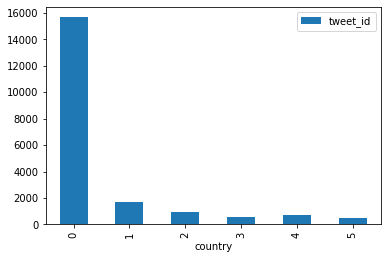

In [159]:
sample_df.groupby('country').agg('count').reset_index().plot(x='country', y = 'tweet_id', kind = 'bar')

In [160]:
!pip install datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [161]:
from datasets import Dataset

In [162]:
test_size = 0.2
val_size = 0.2

y = sample_df['country']

X = sample_df

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size,random_state = 630, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,random_state = 630, test_size = val_size / (1 - test_size), stratify = y_train)


In [163]:
# train, validate, test = np.split(sample_df.sample(frac=1), [int(.6*len(sample_df)), int(.8*len(sample_df))])
train, validate, test = X_train, X_val, X_test

<AxesSubplot:xlabel='country'>

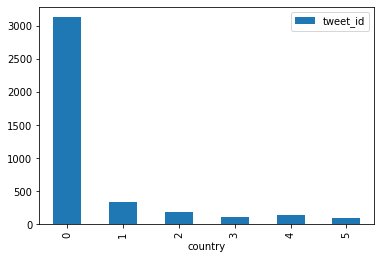

In [164]:
validate.groupby('country').agg('count').reset_index().plot(x='country', y = 'tweet_id', kind = 'bar')

In [165]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index = False)
validate.to_csv('validate.csv', index = False)

In [166]:
ds_train = Dataset.from_csv('train.csv')
ds_val = Dataset.from_csv('validate.csv')
ds_test = Dataset.from_csv('test.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/srtoner/.cache/huggingface/datasets/csv/default-d60bacd12d8e5c29/0.0.0. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/srtoner/.cache/huggingface/datasets/csv/default-e92fd9abdbb8e070/0.0.0. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/srtoner/.cache/huggingface/datasets/csv/default-ddb77d6cec340cd1/0.0.0. Subsequent calls will reuse this data.


In [167]:
ds = {"train": ds_train, "validation": ds_val, "test": ds_test}

In [168]:
ds_train[0]

{'user_id': 18777886,
 'tweet_id': 1617297305266167810,
 'tweet_text': 'I still think we’re in good shape to win it in 2037.',
 'country': 0}

In [169]:
ds_val

Dataset({
    features: ['user_id', 'tweet_id', 'tweet_text', 'country'],
    num_rows: 4000
})

In [170]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base", num_labels=6, id2label=id2label, label2id=label2id)
# model = AutoModelForSequenceClassification.from_pretrained("Twitter/twhin-bert-base", num_labels=6, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and

In [171]:
model = model.to(device)

In [172]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, DataCollatorWithPadding
# tokenizer = AutoTokenizer.from_pretrained('Twitter/twhin-bert-base')
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base')

In [173]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Using old preprocessing function for now, baseline results
def preprocess_function(examples):
    label = examples["country"] 
#     examples['tweet_text'].apply(preprocess)
    examples = tokenizer(preprocess(examples["tweet_text"]), truncation=True, padding="max_length", max_length=256, return_tensors='pt')
#     examples = tokenizer(examples["tweet_text"], truncation=True, padding="max_length", max_length=256, return_tensors='pt')
    
    for key in examples:
        examples[key] = examples[key].squeeze(0)#.to(device)
    examples["label"] = torch.IntTensor([label])
    examples = examples.to(device)
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=['user_id', 'tweet_id', 'tweet_text', 'country'])
    ds[split].set_format('pt')

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [174]:
example = next(iter(ds['train']))

In [175]:
example

{'input_ids': tensor([   0,  100,  202,  206,   52,   17,   27,  241,   11,  205, 3989,    7,
          339,   24,   11,  291, 3272,    4,    2,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1, 

In [176]:
tokenizer.decode(example['input_ids'])

'<s>I still think we’re in good shape to win it in 2037.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [177]:
ds['train']["label"][:10]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [5]])

In [178]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [179]:
import evaluate

accuracy = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

In [180]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": accuracy.compute(predictions=predictions, references=labels), 
            "f1":f1_metric.compute(predictions=predictions, references=labels, average="weighted")}

In [181]:
import torch
class TwitterTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = torch.nn.functional.cross_entropy(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [182]:
from transformers import TrainingArguments
from transformers import Trainer


# tb = TensorBoardCallback()

In [183]:
training_args = TrainingArguments(
    output_dir=f"my_awesome_model_{suffix}",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = TwitterTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics,
#     callbacks = [tb]
)


In [184]:
trainer.train()

/home/srtoner/.local/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.632721,{'accuracy': 0.83025},{'f1': 0.7940259845590072}
2,0.690800,0.623528,{'accuracy': 0.83},{'f1': 0.7969843957738725}


Trainer is attempting to log a value of "{'accuracy': 0.83025}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.7940259845590072}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.83}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.7969843957738725}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=750, training_loss=0.6541363525390625, metrics={'train_runtime': 377.3273, 'train_samples_per_second': 63.605, 'train_steps_per_second': 1.988, 'total_flos': 3157446057984000.0, 'train_loss': 0.6541363525390625, 'epoch': 2.0})

In [185]:
trainer.evaluate()

Trainer is attempting to log a value of "{'accuracy': 0.83}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.7969843957738725}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.6235279440879822,
 'eval_accuracy': {'accuracy': 0.83},
 'eval_f1': {'f1': 0.7969843957738725},
 'eval_runtime': 17.3913,
 'eval_samples_per_second': 230.001,
 'eval_steps_per_second': 7.188,
 'epoch': 2.0}

In [186]:
predictions = trainer.predict(ds['test'])

In [187]:
predictions[0].shape

(4000, 6)

In [188]:
predictions[0]

array([[ 4.2847133 , -0.27015972,  0.3017845 , -0.7715713 , -1.8178804 ,
        -1.7762793 ],
       [ 3.387873  ,  0.05175307,  0.07762962, -0.6135988 , -1.5923916 ,
        -1.5148026 ],
       [-0.5570164 ,  3.0411177 , -0.8116897 ,  0.31662115, -1.4324602 ,
        -1.71304   ],
       ...,
       [ 4.8565683 , -0.80110407,  0.1462752 , -1.0882511 , -1.537969  ,
        -1.4444994 ],
       [ 3.6830537 ,  0.12615709,  0.09096619, -0.6428648 , -1.804723  ,
        -1.8298155 ],
       [ 2.4223847 ,  0.48508424,  0.5209821 , -0.09227211, -1.6409272 ,
        -2.2026155 ]], dtype=float32)

In [189]:
from sklearn.metrics import confusion_matrix

In [190]:
predictions_array = np.argmax(predictions[0], axis = 1)

In [191]:
predictions_array.shape

(4000,)

In [192]:
labels_array = predictions[1]
labels_array.shape

(4000,)

In [193]:
confusion_matrix(labels_array, predictions_array)

array([[3048,   57,   15,    0,    7,    7],
       [ 198,  131,    0,    0,    4,    3],
       [ 144,   11,   22,    0,    3,    1],
       [  76,   26,    3,    2,    4,    2],
       [  69,    3,    0,    0,   66,    2],
       [  59,    3,    0,    0,    1,   33]])

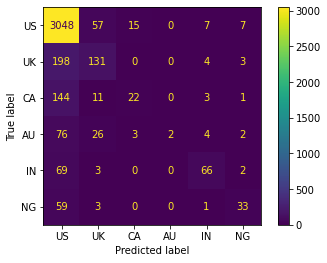

In [194]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(labels_array, predictions_array)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm,
                                    display_labels = ['US', 'UK', 'CA', 'AU', 'IN', 'NG'])
cm_display.plot();

In [195]:
trainer.save_model(f'twitter_{suffix}')

In [196]:
breadcrumbs = (ds['test'], predictions)

In [197]:
import pickle as pkl
with open (f"{suffix}_results.pkl", "wb") as f:
    pkl.dump(breadcrumbs, f)